# Spectral Calibration Matrix making

March 7th, 2024
Neerja Aggarwal

The goal of this notebook is to take the tiff images acquired using the Monochromator and Spectral Camera.  
And then process them into a spectral filter matrix. 
Then I can also normalize based on the cornerstone power. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sdc_config4 as sdc
import os

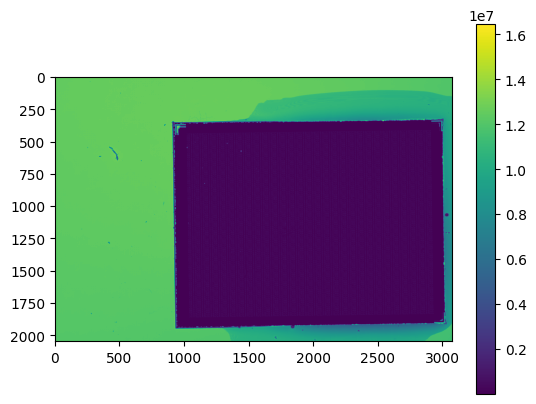

In [2]:
# import the tiff files in a directory
def import_tiff_files(directory):
    # get the list of files in the directory
    files = os.listdir(directory)
    # get the tiff files
    tiff_files = [f for f in files if f.endswith('.tiff')]
    # sort the files
    tiff_files.sort()
    # get the number of files
    n_files = len(tiff_files)
    # get the first file
    first_file = tiff_files[0]
    # get the shape of the first file
    shape = plt.imread(directory + first_file).shape
    # create an empty array to store the tiff files
    tiff_array = np.zeros((n_files, shape[0], shape[1]), dtype=np.uint16)
    # import the tiff files
    for i in range(n_files):
        tiff_array[i, :, :] = plt.imread(directory + tiff_files[i])
    return tiff_array


# import calibration data tiff files. The calibration data is the filter stack # IGNORE THE UV DATA IN THIS FOLDER SINCE ITS WRONG
filter_stack_directory = '/home/neerja/CODE/SpectralDiffuserScopeGitRepo/JaxCode/spectralcalibration_400to900_every2nm_2nmFWHM/'
filter_stack = import_tiff_files(filter_stack_directory)
filter_stack.shape

# Make the wavelength vector
wvstart = 400
wvend = 900
wvstep = 2
wv = np.arange(wvstart, wvend+wvstep, wvstep)

msum = filter_stack.sum(axis=0)
plt.imshow(msum)
# plt.xlim(1000,2900)
# plt.ylim(1800,400)
plt.colorbar()

# explore the minimums

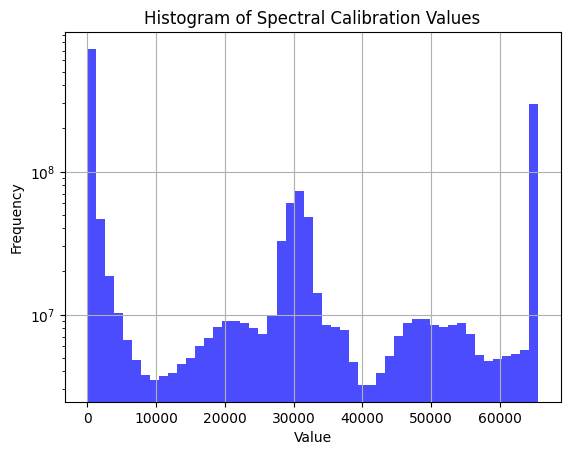

In [170]:
import numpy as np
import matplotlib.pyplot as plt

# Example datacube, replace this with your actual 3D ndarra
# Flatten the datacube to a 1D array
data_flat = filter_stack.flatten()

plt.figure()
# Plotting the histogram
plt.hist(data_flat, bins=50, color='blue', alpha=0.7, log = True)
plt.title('Histogram of Spectral Calibration Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


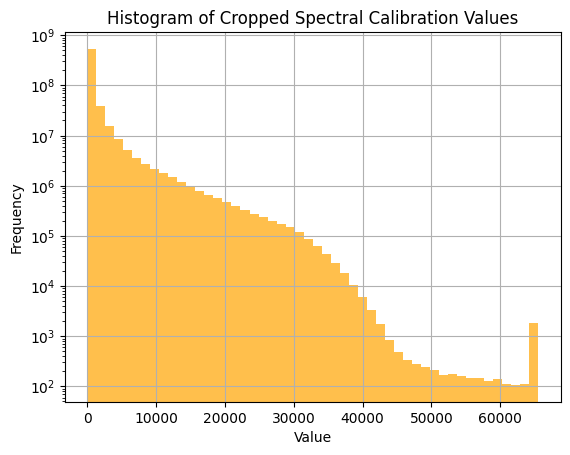

In [171]:
# check the cropped cube
filter_stack_cropped =  filter_stack[:,500:1800, 1000:2900]
data_cropped_flat =filter_stack_cropped.flatten()

plt.figure()
# Plotting the histogram
plt.hist(data_cropped_flat, bins=50, color='orange', alpha=0.7, log = True)
plt.title('Histogram of Cropped Spectral Calibration Values')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


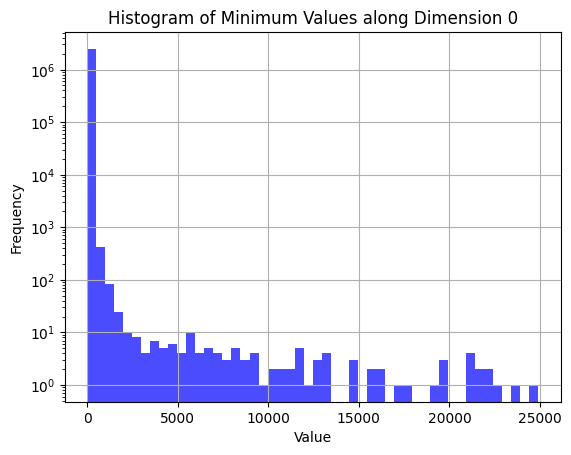

In [172]:
# plot histogram of the minimum value along dimension 0. 
min_values = np.min(filter_stack_cropped, axis=0)
min_values_flat = min_values.flatten()

plt.figure()
plt.hist(min_values_flat, bins=50, color='blue', alpha=0.7, log = True)
plt.title('Histogram of Minimum Values along Dimension 0')
plt.xlabel('Value')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


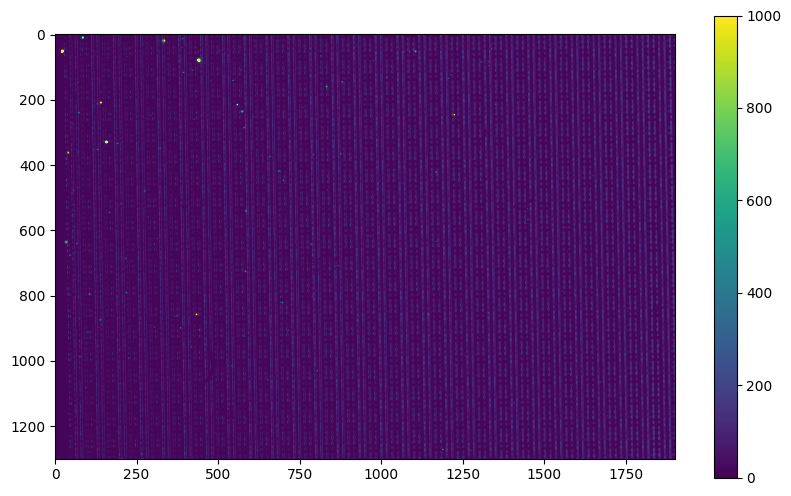

In [173]:
# plot the minimum along each pixel. 
plt.figure(figsize = (10,6))
plt.imshow(min_values)
plt.colorbar()
# plt.clim([0,1e3])

# look into normalizing by optical power curve

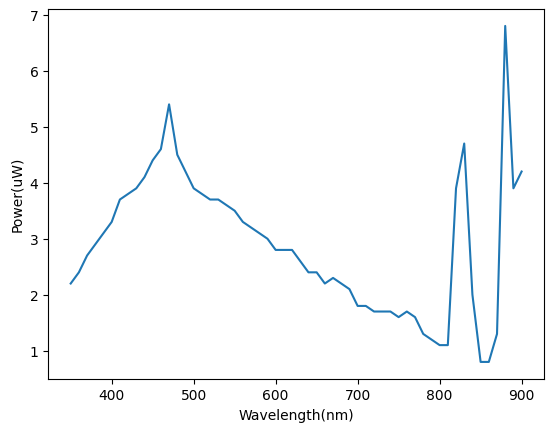

In [3]:
import csv

# import the normalization data
# Specify the file path
file_path = '/home/neerja/CODE/SpectralDiffuserScopeGitRepo/JaxCode/Calibration_data/cornerstone_power_20240223.csv'

# Create empty lists to store the data
column1 = []
column2 = []

# Open the CSV file
with open(file_path, 'r') as file:
    # Create a CSV reader object
    reader = csv.reader(file)
    
    # Skip the title row
    next(reader)
    
    # Read each row and append the data to the respective lists
    for row in reader:
        column1.append(float(row[0]))
        column2.append(float(row[1]))

# Convert the lists to numpy arrays
wv_pwr = np.array(column1)
pwr = np.array(column2)
plt.plot(wv_pwr,pwr)
plt.xlabel('Wavelength(nm)')
plt.ylabel('Power(uW)')

# interpolate wv_pwr and pwr to match wv
from scipy.interpolate import interp1d
f = interp1d(wv_pwr, pwr, kind='linear')
pwr_interp = f(wv)

pwr_interp_norm = pwr_interp / max(pwr_interp)

In [4]:
pwr_interp_norm_expand = np.expand_dims(pwr_interp_norm, axis = [1,2])
filter_stack_normalized = np.divide(filter_stack, pwr_interp_norm_expand)  # checked  its working correctly


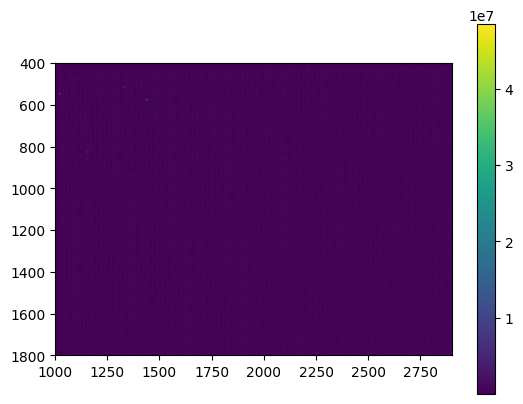

In [5]:
msum_norm = filter_stack_normalized.sum(axis=0)
plt.imshow(msum_norm)
plt.xlim(1000,2900)
plt.ylim(1800,400)
plt.colorbar()

In [6]:
from ipywidgets import interact, IntSlider

def plot_slice(slice_index):
    plt.figure(figsize=(10, 10))
    plt.imshow(filter_stack_normalized[slice_index, :, :])
    plt.xlim(2000,2200)
    plt.ylim(1000,1200)
    plt.title(wv[slice_index])
    plt.colorbar()
    plt.show()

interact(plot_slice, slice_index=IntSlider(min=0, max=filter_stack_normalized.shape[0]-1, step=1, value=0))

interactive(children=(IntSlider(value=0, description='slice_index', max=250), Output()), _dom_classes=('widget…

<function __main__.plot_slice(slice_index)>

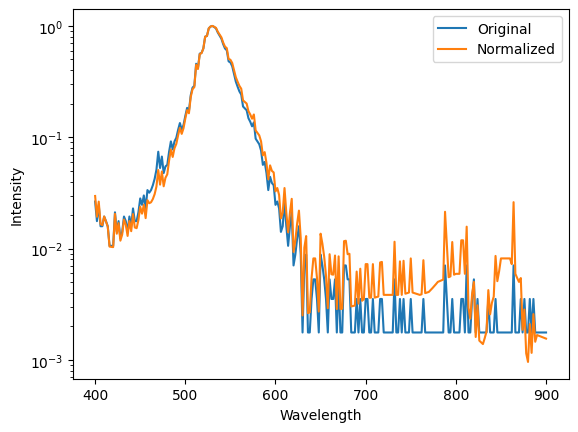

In [7]:
plt.plot(wv,filter_stack[:,1500,2200]/max(filter_stack[:,1500,2200]), label = 'Original')
plt.semilogy(wv,filter_stack_normalized[:,1500,2200]/max(filter_stack_normalized[:,1500,2200]), label = 'Normalized')
plt.xlabel('Wavelength')
plt.ylabel('Intensity')
plt.legend()

(1100.0, 1200.0)

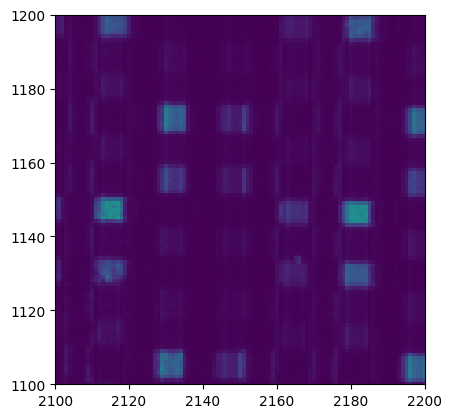

In [9]:
superpixel = filter_stack[:,1000:1100,2000:2100]
plt.imshow(superpixel.sum(axis = 0))
idy,idx= [65,30]

plt.imshow(filter_stack_normalized[50,:,:])
plt.xlim(2100,2200)
plt.ylim(1100,1200)